# Welcome to CS 5242 **Homework 7**

ASSIGNMENT DEADLINE ⏰ : **6 Nov 2022, 23:59**

In this assignment, we have three questions. This is the third question and please write the answer in this notebook.

Colab is a hosted Jupyter notebook service that requires no setup to use, while providing access free of charge to computing resources including GPUs. In this semester, we will use Colab to run our experiments.

### **Grades Policy**

We have 10 points for this homework. 15% off per day late, 0 scores if you submit it 7 days after the deadline.

### **Cautions**

**DO NOT** copy the code from the internet, e.g. GitHub.

**DO NOT** use external libraries like Tensorflow, keras in your implementation.

---

### **Contact**

Please feel free to contact us if you have any question about this homework or need any further information.

Slack (Recommend): Lin Qiuxia

TA Email: qiuxia.lin@u.nus.edu

> If you have not join the slack group, you can click [here](https://join.slack.com/t/cs5242ay20222-oiw1784/shared_invite/zt-1eiv24k1t-0J9EI7vz3uQmAHa68qU0aw)

# Question 3 (3 Points)
In this question, we will implement a Deep Convolutional GANs to generate face images. 

Most codes are provided and a few codes are missing. Please enter your codes in the highlighted parts and run all the cells to provide proper outputs. 

Feel free to adjust model hyperparameter values when training the model. 

In [1]:
!wget https://www.dropbox.com/s/nasiwc4nxs68cm7/male_female_face_images.zip
!unzip -q male_female_face_images.zip

--2022-11-05 07:49:01--  https://www.dropbox.com/s/nasiwc4nxs68cm7/male_female_face_images.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/nasiwc4nxs68cm7/male_female_face_images.zip [following]
--2022-11-05 07:49:02--  https://www.dropbox.com/s/raw/nasiwc4nxs68cm7/male_female_face_images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca1bc5b826681bf93cb2a0ab99f.dl.dropboxusercontent.com/cd/0/inline/BwI_KNwnybbFQVFbolyfZmbA9Ew1f6etydwqsvW-pNnri9FeIdbbq8fti4h9bwr4uFC6FeHLp5Wyjem3fyinc-Crn7_D2htxz-PdfvdZI2cR9nYgPwJv1Jc41gPnxO58ciBIcu4-fI7J8Ytf6_0ySh-hIRwDIA2w6iX4R7JKZUfgHA/file# [following]
--2022-11-05 07:49:02--  https://uca1bc5b826681bf93cb2a0ab99f.dl.dropboxusercontent.com/cd/0/inline/BwI_KNwnybbFQVFbolyfZmbA9Ew1f6etyd

In [2]:
!pip install -q --upgrade torch_snippets
from torch_snippets import *
import torchvision
from torchvision import transforms
import torchvision.utils as vutils
import cv2, numpy as np, pandas as pd
device = "cuda" if torch.cuda.is_available() else "cpu"

     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 58 kB 6.6 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 237 kB 60.9 MB/s 
     |████████████████████████████████| 1.6 MB 65.4 MB/s 
     |████████████████████████████████| 175 kB 76.8 MB/s 
     |████████████████████████████████| 2.2 MB 53.6 MB/s 
     |████████████████████████████████| 51 kB 8.7 MB/s 


In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [5]:
!mkdir cropped_faces
images = Glob('content/females/*.jpg')+Glob('content/males/*.jpg')
for i in range(len(images)):
    img = read(images[i],1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        img2 = img[y:(y+h),x:(x+w),:]
    cv2.imwrite('cropped_faces/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

mkdir: cannot create directory ‘cropped_faces’: File exists


In [6]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
class Faces(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(Glob(folder))
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

In [8]:
ds = Faces(folder='cropped_faces/')

In [9]:
dataloader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_act1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_bn_act2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_bn_act3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_bn_act4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        self.conv_act5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=(4,4), stride=(1,1), bias=False),
            nn.Sigmoid()
        )
   
    def forward(self, input):
        x = self.conv_act1(input)
        x = self.conv_bn_act2(x)
        x = self.conv_bn_act3(x)
        x = self.conv_bn_act4(x)
        x = self.conv_act5(x)
        return x

In [11]:
!pip install torch_summary
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator,torch.zeros(1,3,64,64));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 32, 32]          --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          3,072
|    └─LeakyReLU: 2-2                    [-1, 64, 32, 32]          --
├─Sequential: 1-2                        [-1, 128, 16, 16]         --
|    └─Conv2d: 2-3                       [-1, 128, 16, 16]         131,072
|    └─BatchNorm2d: 2-4                  [-1, 128, 16, 16]         256
|    └─LeakyReLU: 2-5                    [-1, 128, 16, 16]         --
├─Sequential: 1-3                        [-1, 256, 8, 8]           --
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           524,288
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-8                    [-1, 256, 8, 8]           --
├─Sequential: 1-4                        

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.conv_t_bn_act1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=(4,4), stride=(1,1), bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv_t_bn_act2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv_t_bn_act3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv_t_bn_act4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv_t_act5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
            nn.Tanh()
        )
   
    def forward(self,input):
        x = self.conv_t_bn_act1(input)
        x = self.conv_t_bn_act2(x)
        x = self.conv_t_bn_act3(x)
        x = self.conv_t_bn_act4(x)
        x = self.conv_t_act5(x)
        return x

In [14]:
generator = Generator().to(device)
summary(generator,torch.zeros(1,100,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
├─Sequential: 1-2                        [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
├─Sequential: 1-3                        [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
├─Sequential: 1-4                        [-1, 64, 32, 32]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 4, 4]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─ReLU: 2-3                         [-1, 512, 4, 4]           --
├─Sequential: 1-2                        [-1, 256, 8, 8]           --
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─ReLU: 2-6                         [-1, 256, 8, 8]           --
├─Sequential: 1-3                        [-1, 128, 16, 16]         --
|    └─ConvTranspose2d: 2-7              [-1, 128, 16, 16]         524,288
|    └─BatchNorm2d: 2-8                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
├─Sequential: 1-4                        [-1, 64, 32, 32]      

In [15]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [16]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)) # Feel free to adjust the optimizer hyperparameters
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) # Feel free to adjust the optimizer hyperparameters

EPOCH: 25.000  d_loss: 0.058  g_loss: 4.341  (1256.45s - 0.00s remaining)

100%|██████████| 126/126 [00:00<00:00, 177.64it/s]


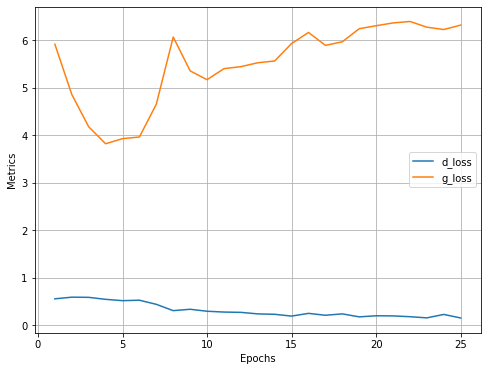

In [17]:
log = Report(25)
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')

log.plot_epochs(['d_loss','g_loss'])

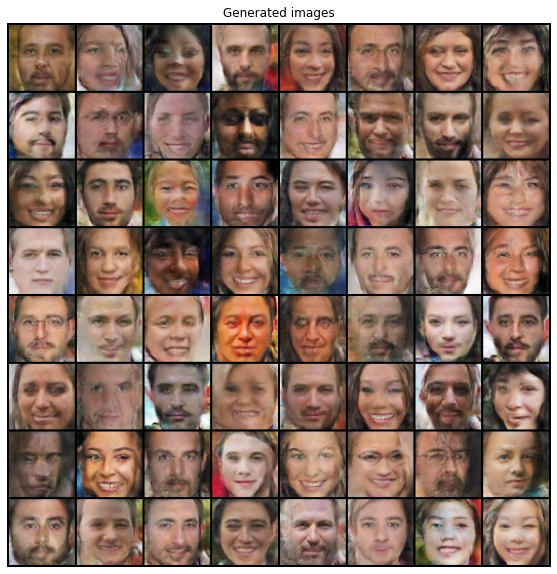

In [26]:
generator.eval()
noise = torch.randn(64, 100, 1, 1, device=device)
sample_images = generator(noise).detach().cpu()
grid = vutils.make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=10, title='Generated images')